In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from ast import literal_eval
from numpy import nan
import xgboost
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from fancyimpute import KNN
import missingno as msno
from copy import deepcopy
import impyute.imputation.cs.mice as mice_imputation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score, explained_variance_score, median_absolute_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
import shap
import matplotlib.gridspec as gridspec


pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 120)

In [2]:
def mape(y_actual, y_pred):
    y_actual = y_actual['lifespan'].tolist()
    y_pred = [i[0] if type(i) == list else i for i in y_pred.tolist()]
    return (np.sum([np.abs((i-j)/i) for i,j in zip(y_actual, y_pred)])*100)/len(y_actual)

def regression_report(y_true, y_pred):
    ev = explained_variance_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    try:
        msle = mean_squared_log_error(y_true, y_pred)
    except:
        msle = "error"
    medal = median_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape_score = mape(y_true, y_pred)
    response = {
        "Explained Variance": ev,
        "Mean Squared Error": mse,
        "Mean Absolute Error": mae,
        "Mean Squared Log Error": msle,
        "Median Absolute Error": medal,
        "MAPE": mape_score,
        "r2_score": r2,
        "RMSE": mse**0.5
    }
    return response

In [3]:
df = pd.read_csv("output/NAG_DETAILS_v8.csv")

In [4]:
delete = ["nag_name", "ideology(s)",'objective(s)']
df.drop(delete, axis=1, inplace=True)

In [113]:
X = df.drop(['nagcode_1', 'lifespan'], axis=1)
y = df[['lifespan']]
# X_complete = mice_imputation(X.values)
X_complete = KNN(k=4).fit_transform(X.values)
X = pd.DataFrame(X_complete, columns=X.columns)

Imputing row 1/459 with 0 missing, elapsed time: 0.153
Imputing row 101/459 with 0 missing, elapsed time: 0.159
Imputing row 201/459 with 24 missing, elapsed time: 0.163
Imputing row 301/459 with 0 missing, elapsed time: 0.174
Imputing row 401/459 with 0 missing, elapsed time: 0.183


In [8]:
'''
Model-III: Using Xgboost for regression.


'''

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)


model = XGBRegressor(**{'colsample_bytree': 0.7,
 'gamma': 0.2,
 'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 3,
 'n_estimators': 300})
model.fit(X_train, y_train) 

Y_pred=model.predict(X_test)
Y_pred_train=model.predict(X_train)


regression_report(y_train, Y_pred_train), regression_report(y_test, Y_pred)

({'Explained Variance': 0.999826349430592,
  'MAPE': 4.03094133012971,
  'Mean Absolute Error': 0.11636591915863412,
  'Mean Squared Error': 0.025577501875116974,
  'Mean Squared Log Error': 0.0017967142994486998,
  'Median Absolute Error': 0.08474159240722656,
  'RMSE': 0.1599296779060002,
  'r2_score': 0.9998263494305909},
 {'Explained Variance': 0.8300920977374475,
  'MAPE': 72.70605064659799,
  'Mean Absolute Error': 3.611051433760187,
  'Mean Squared Error': 28.531706077158887,
  'Mean Squared Log Error': 0.24291337121278486,
  'Median Absolute Error': 2.4891120195388794,
  'RMSE': 5.3415078467749995,
  'r2_score': 0.8298822450357344})

In [15]:
model = XGBRegressor(**{'colsample_bytree': 0.7,
 'gamma': 0.2,
 'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 3,
 'n_estimators': 300})
model.fit(X_train, y_train) 

{'Explained Variance': 0.9621124787719759,
 'MAPE': 17.795886988332498,
 'Mean Absolute Error': 0.8168257608652635,
 'Mean Squared Error': 5.739224187988639,
 'Mean Squared Log Error': 0.05012510740626117,
 'Median Absolute Error': 0.11356544494628906,
 'RMSE': 2.3956677958324355,
 'r2_score': 0.9621031419218687}

In [76]:
model

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.2, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


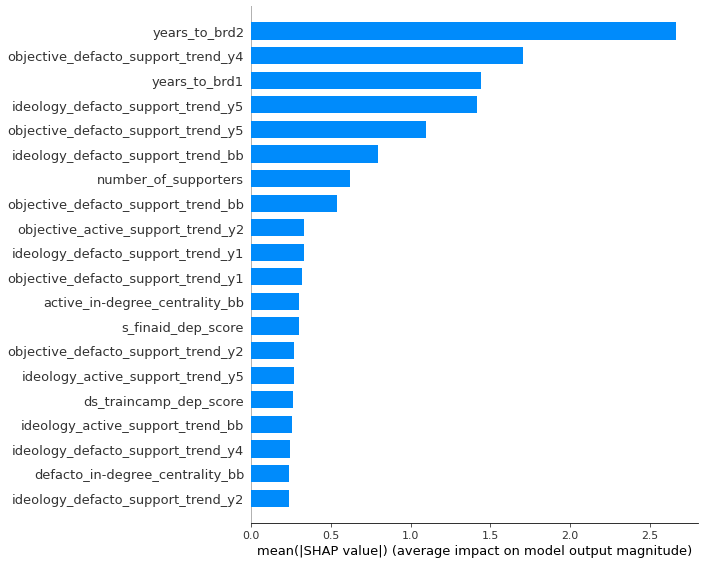

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


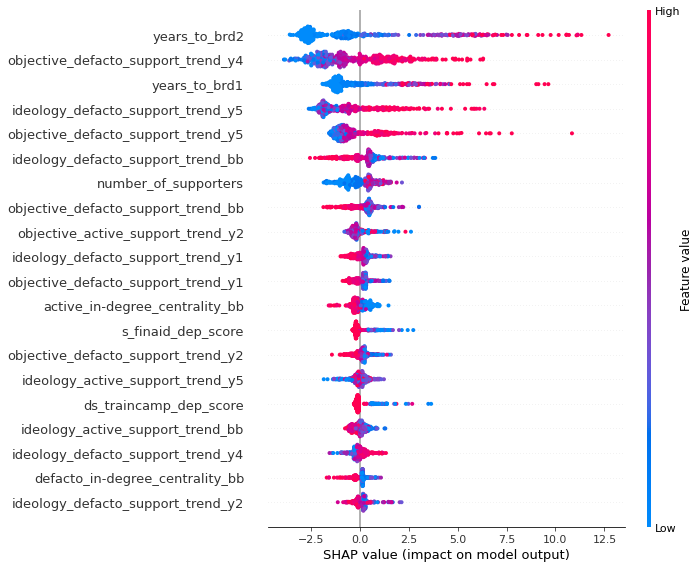

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


In [77]:
Y_pred_complete=model.predict(X)
regression_report(y, Y_pred_complete)

explained = shap.TreeExplainer(model)
shap_values = explained.shap_values(X)

f = plt.figure()
shap.summary_plot(shap_values, X, plot_type="bar")
f.savefig("images/summary_plot1.png", bbox_inches='tight', dpi=600)
f.show()

f = plt.figure()
shap.summary_plot(shap_values, X)
f.savefig("images/summary_plot2.png", bbox_inches='tight', dpi=600)
f.show()

In [50]:
shap.initjs()

In [55]:
shap.force_plot(explained.expected_value, shap_values[102,:], X.iloc[102,:])

In [83]:
%matplotlib inline
fig = shap.force_plot(explained.expected_value, shap_values[419,:], X.iloc[419,:], show=False)
plt.savefig("images/al_qaida.png")

<Figure size 432x288 with 0 Axes>

In [84]:
shap.save_html("images/shap_html.html", fig)

In [64]:
shap.force_plot(explained.expected_value, shap_values, X)

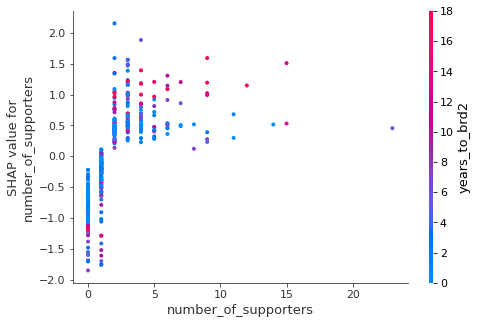

In [90]:
shap.dependence_plot('number_of_supporters', shap_values, X)

In [109]:
X.drop(, axis=1, inplace=True)

In [111]:
X.shape

(459, 83)

[[0, (0, 1)], [0, (1, 2)], [0, (2, 3)], [0, (3, 4)], [0, (4, 5)], [0, (5, 6)], [1, (0, 1)], [1, (1, 2)], [1, (2, 3)], [1, (3, 4)], [1, (4, 5)], [1, (5, 6)], [2, (0, 1)], [2, (1, 2)], [2, (2, 3)], [2, (3, 4)], [2, (4, 5)], [2, (5, 6)], [3, (0, 1)], [3, (1, 2)], [3, (2, 3)], [3, (3, 4)], [3, (4, 5)], [3, (5, 6)]]
number_of_supporters


AssertionError: 'shap_values' must have the same number of columns as 'features'!

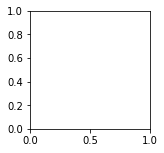

In [112]:
plt.close()
plt.figure(figsize = (15,10))
gs = gridspec.GridSpec(4,6)
rowcols = [[i,(j,j+1)] for i in range(4) for j in range(6)]
index = 0
print(rowcols)
prev_row = -1
for index, col_name in enumerate(X.columns[0:24]):
    if col_name not in ['number_of_ideologies', 'number_of_objectives']:
        row,colA,colB = rowcols[index][0],rowcols[index][1][0],rowcols[index][1][1]
        index+=1
        ax = plt.subplot(gs[row,colA:colB])
        if row != prev_row:
            prev_row = row
            pass
        else:
            ax.get_yaxis().set_visible(False)
        print(col_name)
        shap.dependence_plot(col_name, shap_values, X, show=False, ax = ax, interaction_index=None, color='b')
        plt.xlabel(rotation=30)
    #     plt.title("Lifespan vs {}".format(col_name),size=9)
    
plt.tight_layout()
plt.savefig("images/{}.png".format('dependance_plot_relation'),bbox_inches='tight')
plt.show()

In [30]:
def plot_distribution(df_t, value):
    X = df_t.drop(['lifespan'], axis=1)
    y = df_t[['lifespan']]

    Y_pred_complete=model.predict(X)
    regression_report(y, Y_pred_complete)
    shap_values = shap.TreeExplainer(model).shap_values(X)

    f = plt.figure()
    shap.summary_plot(shap_values, X, plot_type="bar")
    f.savefig("images/summary_plot{}.png".format(value), bbox_inches='tight', dpi=600)
    f.show()

    f = plt.figure()
    shap.summary_plot(shap_values, X)
    f.savefig("images/summary_plot{}.png".format(value+'_corr'), bbox_inches='tight', dpi=600)
    f.show()

In [31]:
df2 =deepcopy(X.merge(y,left_index=True, right_index=True))

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


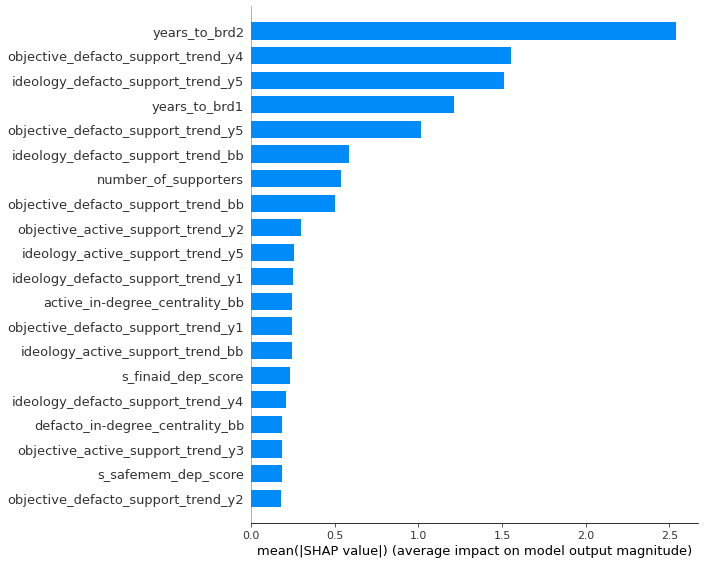

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


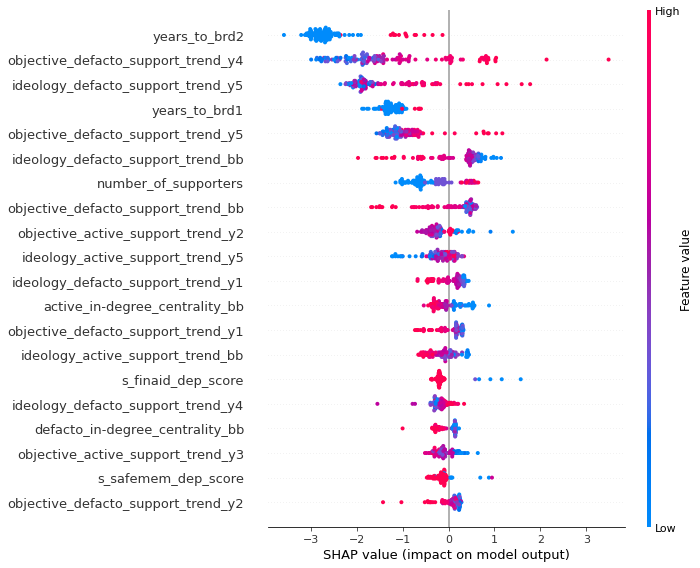

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


In [43]:
plot_distribution(df2[df2['lifespan']<=2], "P25")

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


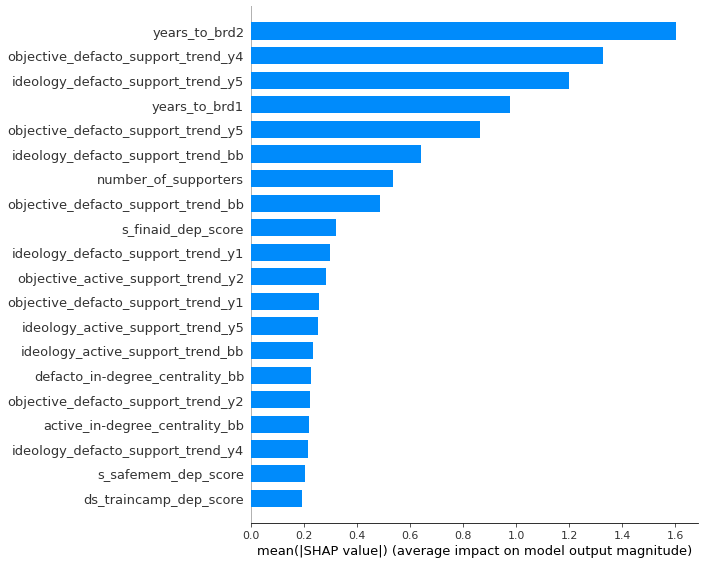

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


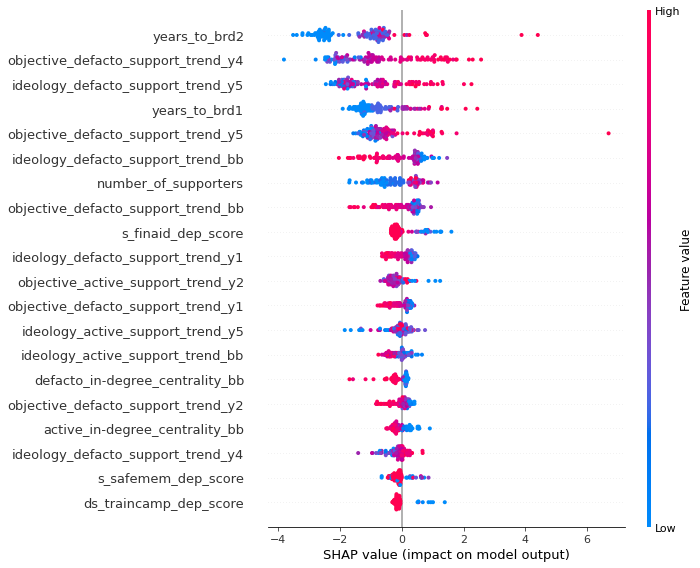

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


In [44]:
plot_distribution(df2[(df2['lifespan']<=7) & (df2['lifespan']>2)], "P50")

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


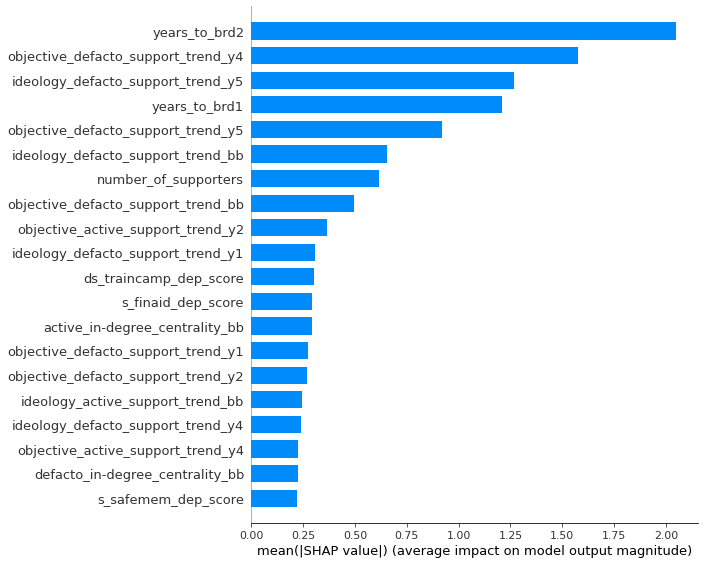

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


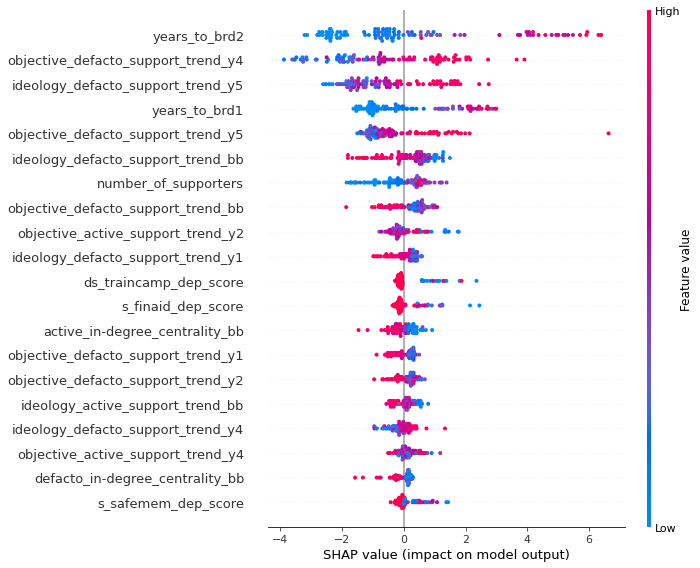

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


In [45]:
plot_distribution(df2[(df2['lifespan']<=17) & (df2['lifespan']>7)], "P75")

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


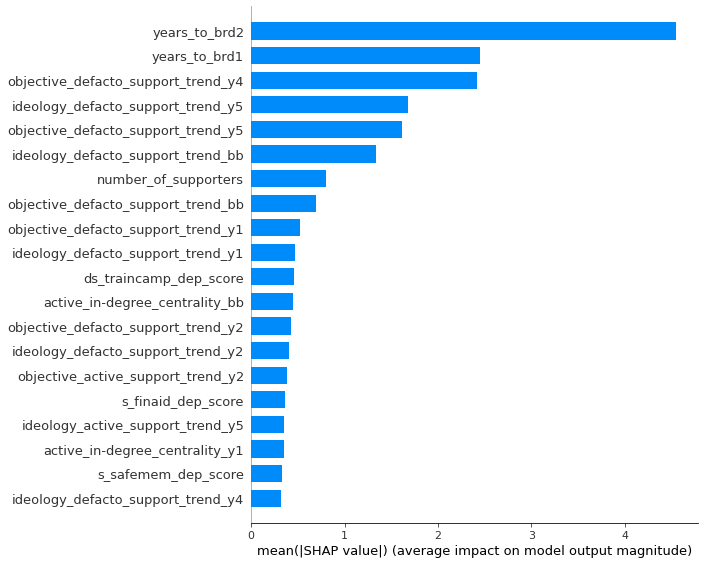

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


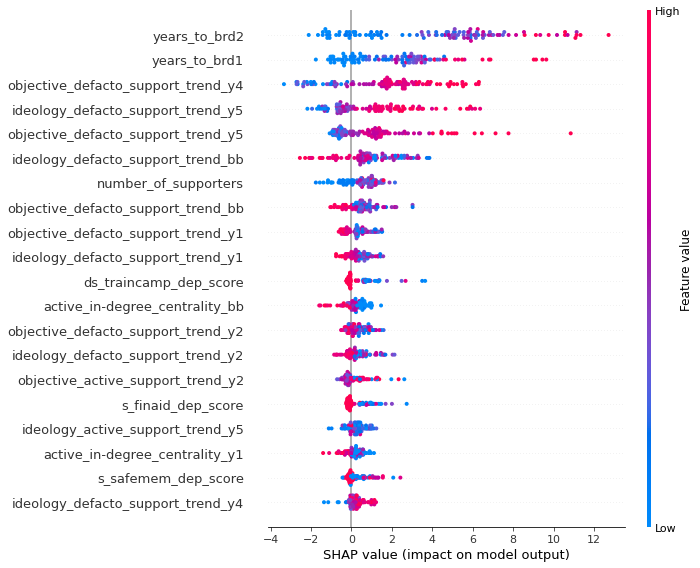

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


In [46]:
plot_distribution(df2[(df2['lifespan']>17)], "P75+")

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


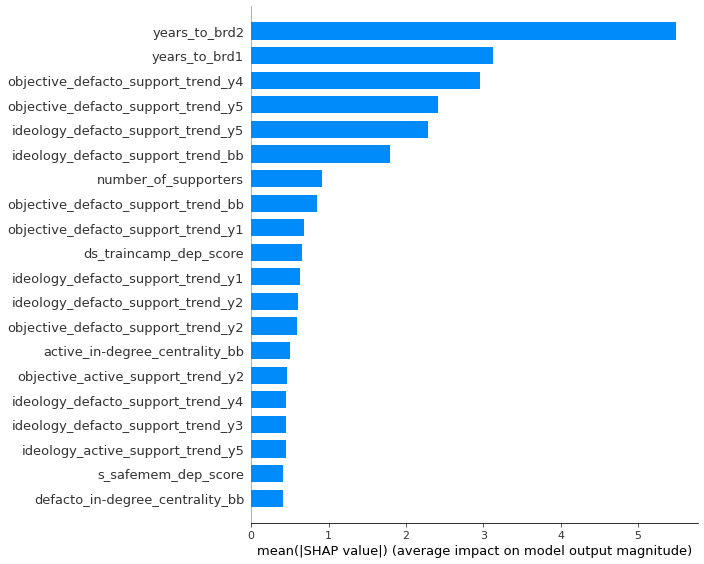

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


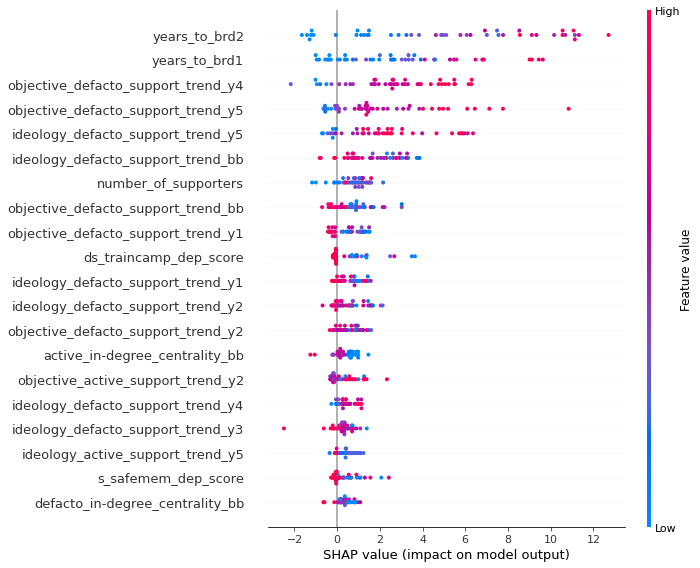

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


In [47]:
plot_distribution(df2[(df2['lifespan']>=32)], "outliers")

In [37]:
np.percentile(df2['lifespan'], 75)

17.0